In [1]:
# Raw video data located at: https://drive.google.com/drive/folders/1dMc5PqYuoaDLSveTv74wsDfpG5zsB0rF?usp=sharing
from __future__ import division, unicode_literals, print_function  
import numpy as np
import matplotlib.pyplot as plt
import pims  # image reading routines
import os

import pandas as pd
#from pandas import DataFrame, Series  

import trackpy as tp
from scipy import ndimage  # for shifting images
from pims import pipeline
from pims import Frame
from scipy.interpolate import griddata  # for resampling
import matplotlib.patches as mpatches   # circles
from scipy.signal import savgol_filter
from skimage.transform import rotate


%load_ext autoreload
%autoreload 2

#from track_lib import  *

from scipy.optimize import curve_fit
# Function to calculate the exponential with constants a and b
def exponential(x, a, b):
    return a*np.exp(b*x)


@pims.pipeline
def gray(image, y0, y1, x0, x1, r, g, b):
    red  = np.array(image[y0:y1, x0:x1, 0])
    redf = red.astype('float')
    green  = np.array(image[y0:y1, x0:x1, 1])
    greenf = green.astype('float')
    blue  = np.array(image[y0:y1, x0:x1, 2])
    bluef = blue.astype('float')

    image = r*redf + g*greenf + b*bluef

    return image

# smooth every image using gaussian filter
from scipy.ndimage import gaussian_filter
@pipeline
def smooth_frame(frame,sigma):
    y= np.array(frame)
    yf = y.astype('float')
    w= gaussian_filter(yf,sigma)
    #i = frame.frame_no
    z= Frame(w)
    #z.frame_no = i  
    return z

#erode image to make processing easier
from scipy.ndimage.morphology import grey_erosion
@pipeline
def erode_frame(frame,sigma):
    y = np.array(frame)
    yf = y.astype('float')
    w = grey_erosion(yf,size=(sigma,sigma))
    #i = frame.frame_no
    z = Frame(w)
    #z.frame_no = i
    return z

#threshold image to make processing easier
@pipeline
def threshold_frame(frame,thresh):
    y = np.array(frame)
    yf = y.astype('float')
    idx = yf[:,:] < thresh
    frame[idx]=0
    #i = frame.frame_no
    z = Frame(frame)
    #z.frame_no = i
    return z

fps = 4532.87
ascale = 4/633 #cm per pixel
sscale = 4/388

/tmp/ipykernel_8567/863922080.py:57: DeprecationWarning: Please use `grey_erosion` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import grey_erosion


# Skip to box 18 if you don't want to do particle tracking (tracked data files are already provided)

In [2]:
646/fps

0.1425145658269485

In [3]:
sframesrgb = pims.open('PTVs-compare.mp4')
sframes = gray(pims.open('PTVs-compare.mp4'), 0, 240, 0, 1280, 0, 1, 0)

/home/mnei/.local/lib/python3.10/site-packages/pims/api.py:204: UserWarning: <class 'pims.pyav_reader.PyAVReaderTimed'> errored: 'NoneType' object has no attribute 'open'
  warn(message)
/home/mnei/.local/lib/python3.10/site-packages/pims/api.py:204: UserWarning: <class 'pims.pyav_reader.PyAVReaderIndexed'> errored: 'NoneType' object has no attribute 'open'
  warn(message)
Exception ignored in: <function PyAVReaderIndexed.__del__ at 0x7f333681f910>
Traceback (most recent call last):
  File "/home/mnei/.local/lib/python3.10/site-packages/pims/pyav_reader.py", line 365, in __del__
    self._container.close()
AttributeError: 'NoneType' object has no attribute 'close'
Exception ignored in: <function PyAVReaderIndexed.__del__ at 0x7f333681f910>
Traceback (most recent call last):
  File "/home/mnei/.local/lib/python3.10/site-packages/pims/pyav_reader.py", line 365, in __del__
    self._container.close()
AttributeError: 'NoneType' object has no attribute 'close'


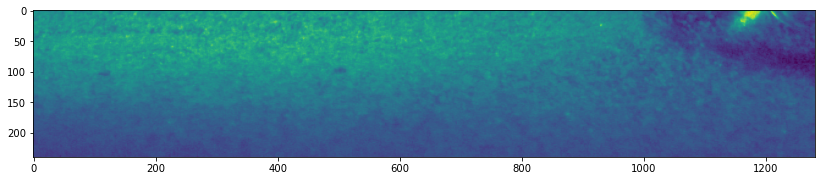

In [5]:
plt.figure(figsize=(14,3))
plt.imshow(sframesrgb[686][0:240,0:1280,2])
f_impact = 646# frame of impact 

In [6]:
40/fps

0.008824431320554086

In [7]:
msframes = gray(sframesrgb,0,240,0,1200,0, 1, 0) #millet side
mpsframes = smooth_frame(msframes,3.0)# millet processead side
ssframes = gray(sframesrgb,0,240,0,1200,0, 1, 0) #sand side
spsframes = smooth_frame(ssframes,3.0) # sand processed side

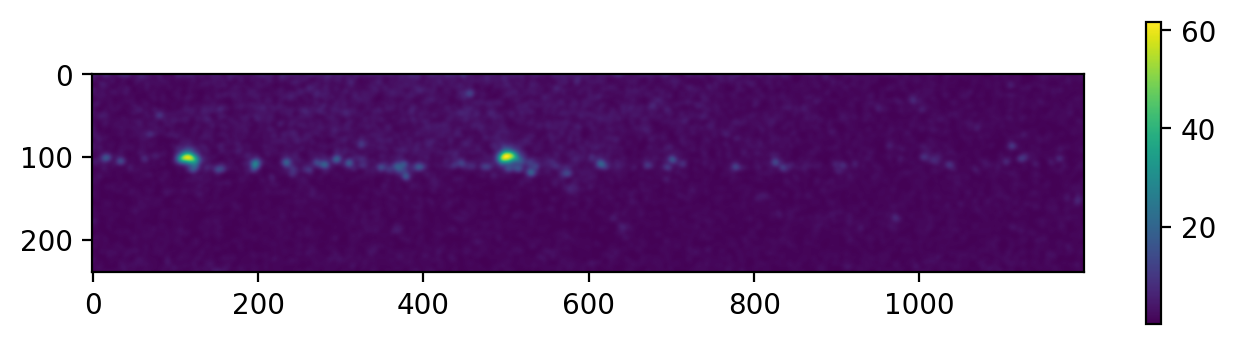

In [8]:
plt.figure(figsize=(8,2),dpi=200); 
plt.imshow(spsframes[600])
plt.colorbar()

In [9]:
fstart = 600
fend = 1200

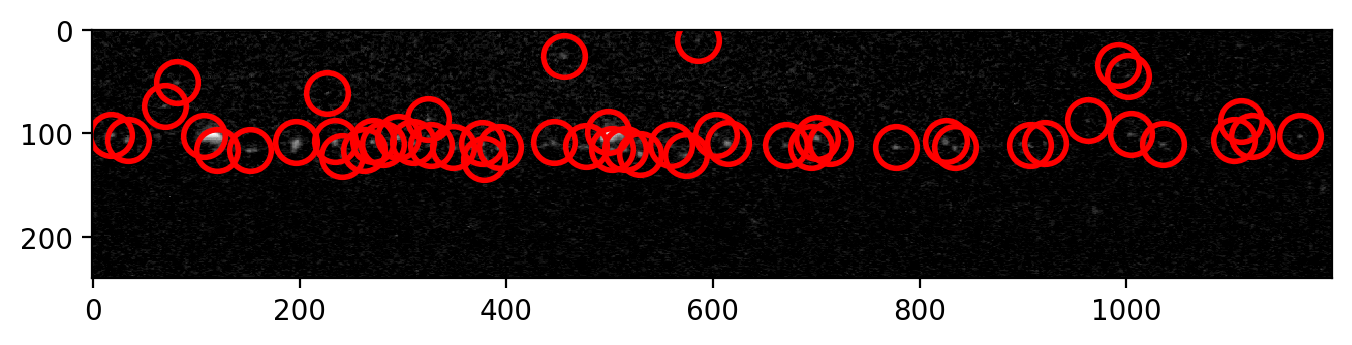

<AxesSubplot:>

In [10]:
plt.figure(figsize=(8,2),dpi=200); 
num = 600
size = 9
thresh = 5
f = tp.locate(ssframes[num], size, invert=False, threshold=thresh)
tp.annotate(f, ssframes[600])

In [11]:
f = tp.batch(ssframes[fstart:fend], size, threshold=thresh, invert=False, processes=1);
t = tp.link(f, 10, memory=10)
tss = tp.filter_stubs(t, 50) #sand from the side

Frame 599: 20 trajectories present.


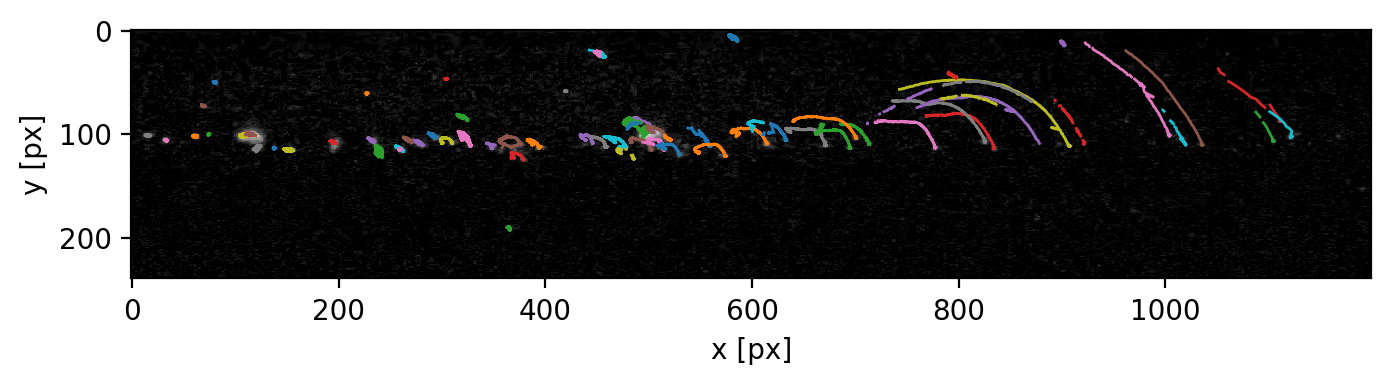

In [12]:
plt.figure(figsize=(8,2),dpi=200);
#plt.figure()
tp.plot_traj(tss, superimpose=ssframes[0], label=False);

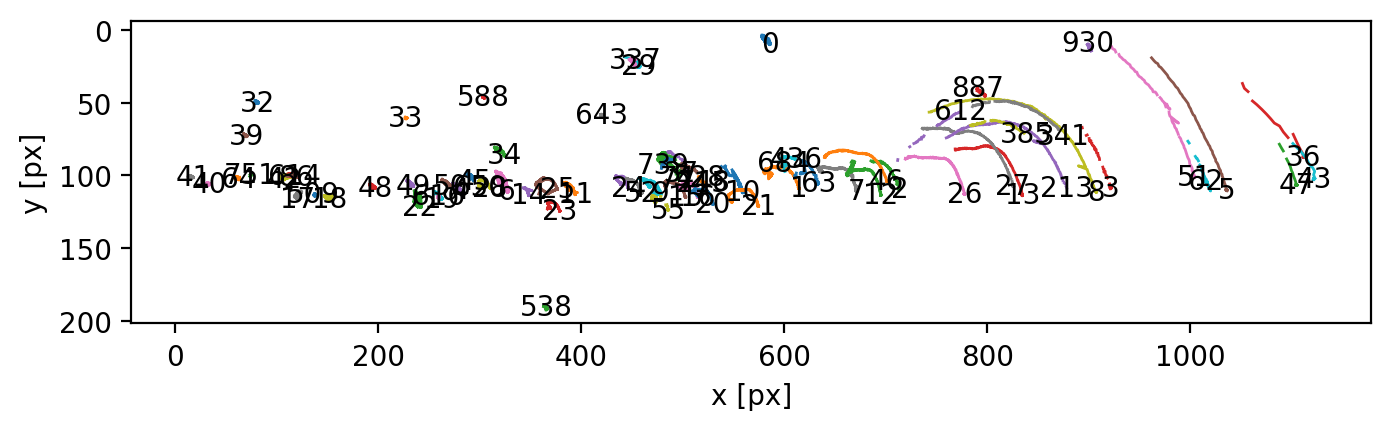

In [13]:
plt.figure(figsize=(8,2),dpi=200);
#plt.figure()
tp.plot_traj(tss, label=True);

In [14]:
f = tp.batch(spsframes[fstart:fend], 7, threshold=1, invert=False, processes=1);
t = tp.link(f, 10, memory=10)
tsps = tp.filter_stubs(t, 50) #sand from the side

Frame 599: 4 trajectories present.


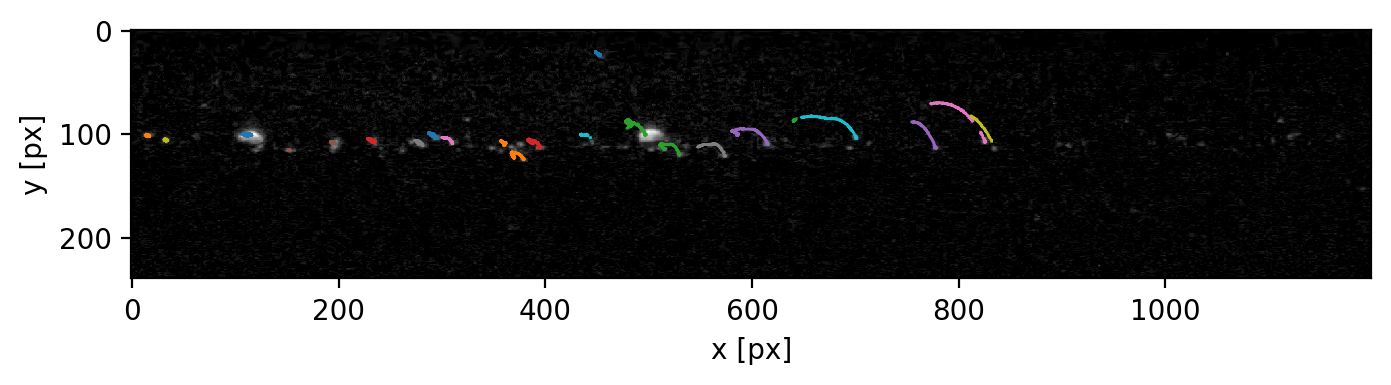

In [15]:
plt.figure(figsize=(8,2),dpi=200);
#plt.figure()
tp.plot_traj(tsps, superimpose=ssframes[0], label=False);

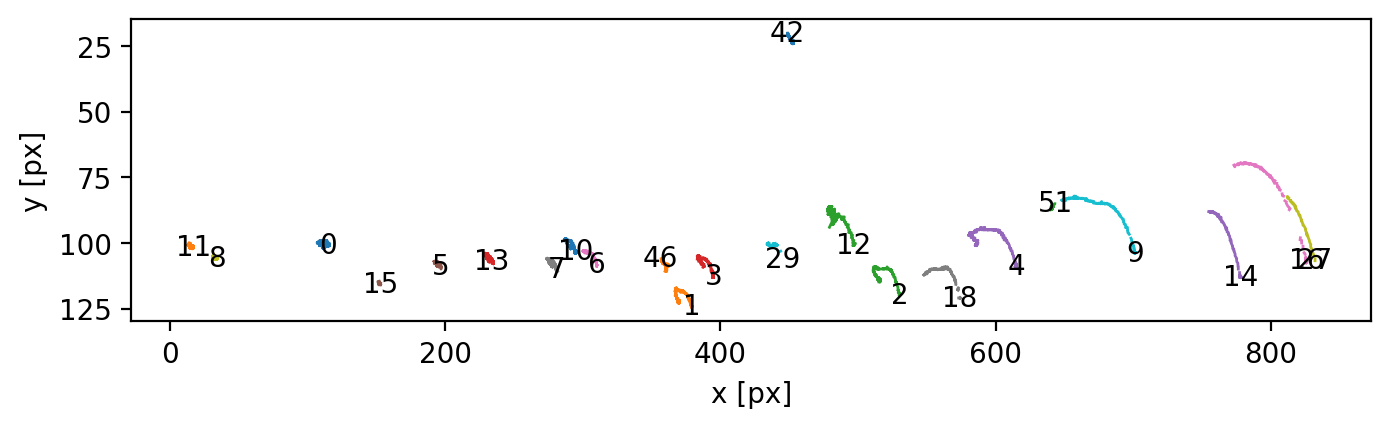

In [16]:
plt.figure(figsize=(8,2),dpi=200);
#plt.figure()
tp.plot_traj(tsps, label=True);

We now have four tracks: messy unsmoothed side (ss), smoothed side (sps), millet grains above (mpa), and sand grains above (spa)

In [17]:
#tss.to_csv('comparess'+'.csv', index=True)
tsps.to_csv('compare_sps'+'.csv', index=True)

# Start here to use the already tracked data

In [18]:
import pandas as pd
fps = 4532.87
ascale = 4/633 #cm per pixel
sscale = 4/388
from scipy.signal import savgol_filter

s1 = pd.read_csv('compare_sps'+'.csv')

#finds number of particles in dataframe df
def fnumpart(df):
    i=0
    k=0
    while(df.loc[i,"particle"]>=k):
        i+=1
        k=int(df.loc[i-1,"particle"])
    return k+1

snumpart = fnumpart(s1)
frames = 600
sdata = np.zeros((2,snumpart,frames)) #(x or y data, particle number, frame number). Put x in 0 and y in 1.

for i in range(snumpart):
    sdata[0,i,:s1.x[s1.particle==i].size]=np.array(s1.x[s1.particle==i])
    sdata[1,i,:s1.y[s1.particle==i].size]=np.array(s1.y[s1.particle==i])
    
sdata = sdata*sscale

avgend = 50

avgs = np.zeros((2,snumpart))
for i in range(snumpart):#creates average value above array
    avgs[0,i]=np.average(sdata[0, i, :avgend])
    avgs[1,i]=np.average(sdata[1, i, :avgend])
    
shifts = np.empty_like(sdata)
for i in range(snumpart):
    shifts[0,i,:]=sdata[0,i,:]-avgs[0,i]
    shifts[1,i,:]=sdata[1,i,:]-avgs[1,i]
    
#create time axis array
seconds = np.zeros(frames)
for i in range(frames):
    seconds[i] = i*(1/fps)

Text(0.5, 1.0, 'radial displacement of grains from side video')

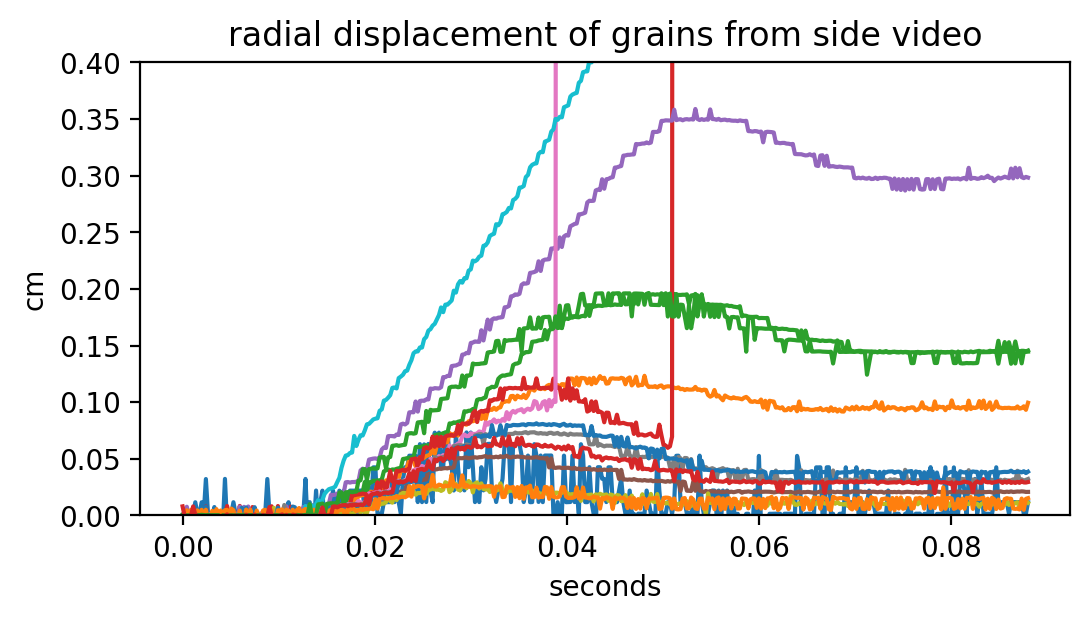

In [19]:
end = 400
plt.figure(figsize=(6,3),dpi=200);
for i in range(snumpart):
    plt.plot(seconds[:end],-1*shifts[0,i,:end])
plt.ylim(0,0.4)
plt.ylabel("cm")
plt.xlabel("seconds")
plt.title("radial displacement of grains from side video")

Note that the two green lines are neighboring sand and millet grains.

Text(0.5, 1.0, 'vertical displacement of grains from side video')

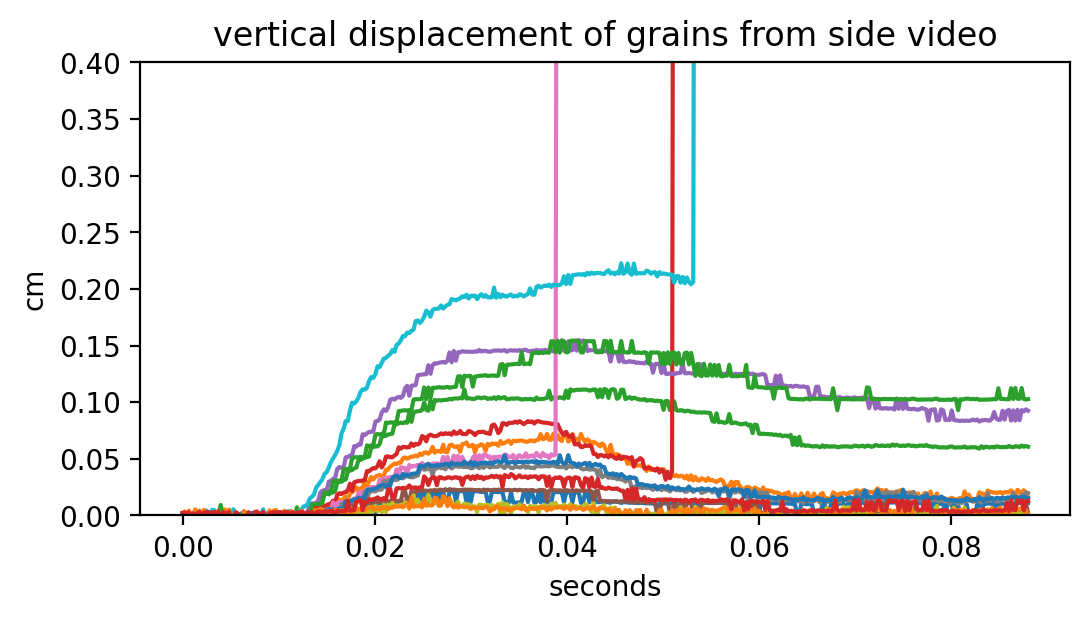

In [20]:
end = 400
plt.figure(figsize=(6,3),dpi=200);
for i in range(snumpart):
    plt.plot(seconds[:end],-1*shifts[1,i,:end])
plt.ylim(0,0.4)
plt.ylabel("cm")
plt.xlabel("seconds")
plt.title("vertical displacement of grains from side video")

In [23]:
accel_xdata = pd.read_csv('SR8-compare_x.csv')
accel_ydata = pd.read_csv('SR8-compare_y.csv')

In [24]:
#Loading accelerometer data from dataframe (need seperate x and y times because the scopes took different length samples)
Timex = np.zeros(accel_xdata.loc[1:,"Time"].size)
Timex[:] = np.array(accel_xdata.loc[1:,"Time"])
Timey = np.zeros(accel_ydata.loc[1:,"Time"].size)
Timey[:] = np.array(accel_ydata.loc[1:,"Time"])
Timex = Timex/1000
Timey = Timey/1000

Accel_xdata = np.zeros((4,accel_xdata.loc[1:,"Time"].size))
Accel_xdata[0,:] = np.array(accel_xdata.loc[1:,"Channel A"])
Accel_xdata[1,:] = np.array(accel_xdata.loc[1:,"Channel B"])

Accel_ydata = np.zeros((4,accel_ydata.loc[1:,"Time"].size))
Accel_ydata[0,:] = np.array(accel_ydata.loc[1:,"Channel A"])
Accel_ydata[1,:] = np.array(accel_ydata.loc[1:,"Channel B"])

(0.0, 0.08)

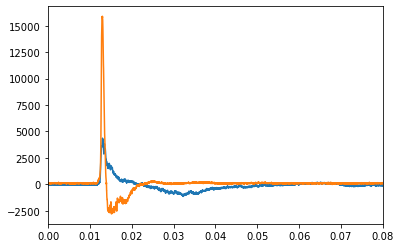

In [25]:
for i in range(2): 
    #1.65 V is 3 g, so 0.55 V is 1 g, so 0.55 V/g * 1g/(981cm/s^2) gives 0.55 V / 981 cm/s^2 or 1784 cm/s/s per V... but we measured 0.3 volts per g... ug
    #so the difference is between 981/0.3 and 981/0.55
    plt.plot(Timex[:]-.13237, (Accel_xdata[i,:]-1.6)*(981/0.06))#we subtract this time because that's the 600 frames we skipped in the particle tracking
    #plt.plot(Timex[:], Accel_ydata[i,:])
#plt.plot(Timex[:]-.13237, Accel_xdata[i,:]-Accel_xdata[i,:]-981*3)
plt.xlim(0, 0.08)

(-2500.0, 2500.0)

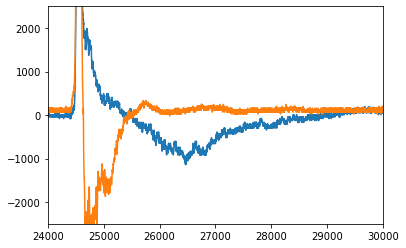

In [26]:
x = np.arange(0, Accel_xdata[0,:].size)
for i in range(2):
    #1.65 V is 3 g, so 0.55 V is 1 g, so 0.55 V/g * 1g/(981cm/s^2) gives 0.55 V / 981 cm/s^2 or 1784 cm/s/s per V... but we measured 0.3 volts per g... ug
    #so the difference is between 981/0.3 and 981/0.55
    plt.plot(x, (Accel_xdata[i,:]-1.6)*(981/0.06))#we subtract this time because that's the 600 frames we skipped in the particle tracking
    #plt.plot(Timex[:], Accel_ydata[i,:])
#plt.plot(Timex[:]-.13237, Accel_xdata[i,:]-Accel_xdata[i,:]-981*3)
plt.xlim(24000,30000)
plt.ylim(-2500,2500)

In [27]:
#Acceleration integrator
def find_baseline(channel):
    sum = 0
    for i in range(10000):
        sum += channel[i]
    return sum/10000

conv = 1#981/0.3 #should this be 0.55?

def integrate_accel(channel, Time):
    baseline = find_baseline(channel)
    velocity = np.zeros(Time.size)
    running_sum = 0
    for i in range(Time.size-1):
        dv = 0.5*(conv*(channel[i]-baseline)+(channel[i+1]-baseline))*(Time[i+1]-Time[i])
        running_sum += dv
        velocity[i] = running_sum
    velocity[i+1] = running_sum
    return velocity

def sub_integrate_vel(channel, lower, higher, Time):
    baseline = find_baseline(channel)
    velocity = np.zeros(Time.size)
    running_sum = 0
    for i in range(lower, higher):
        dv = 0.5*((channel[i]-baseline)+(channel[i+1]-baseline))*(Time[i+1]-Time[i])
        running_sum += dv
        velocity[i] = running_sum
    velocity[i+1] = running_sum
    return velocity

def differentiate(data, f_p_s):
    dx = np.zeros(data.size)
    for i in range(dx.size-1):
        dx[i] = (data[i+1]-data[i])*f_p_s
    return dx

In [28]:
Aaccelx = np.array((Accel_xdata[0,:]-1.6)*(981/0.06))
Baccelx = np.array((Accel_xdata[1,:]-1.6)*(981/0.06))

Aaccely = np.array((Accel_ydata[0,:]-1.66)*(981/0.06))
Baccely = np.array((Accel_ydata[1,:]-1.6)*(981/0.06))

Avelx = integrate_accel(Aaccelx, Timex)
Bvelx = integrate_accel(Baccelx, Timex)

Avely = integrate_accel(Aaccely, Timey)
Bvely = integrate_accel(Baccely, Timey)

Text(0.5, 0, 'seconds')

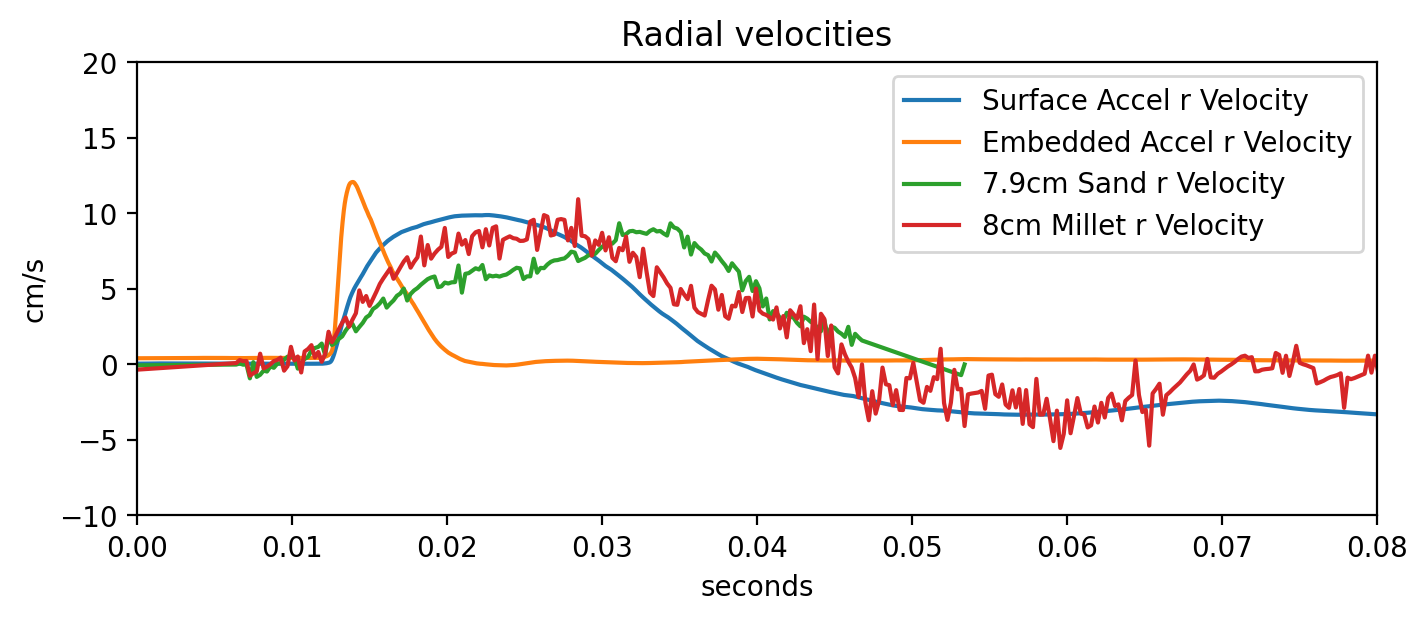

In [29]:
plt.figure(figsize=(8,3),dpi=200); 
plt.plot(Timex[:]-.13237, Avelx[:], label = "Surface Accel r Velocity")
plt.plot(Timex[:]-.13237, Bvelx[:], label = "Embedded Accel r Velocity")
plt.plot(seconds[:243],-1*differentiate(savgol_filter(shifts[0,2,:243],61,2),fps), label = "7.9cm Sand r Velocity")
plt.plot(seconds[:end],-1*differentiate(savgol_filter(shifts[0,12,:end],61,2),fps), label = "8cm Millet r Velocity")
plt.xlim(0, 0.08)
plt.ylim(-10, 20)
plt.legend()
plt.title("Radial velocities")
plt.ylabel("cm/s")
plt.xlabel("seconds")

In [30]:
cc = pd.read_csv("cc_r8cm_displacement.csv", sep=" ")#load cross correlation radial displacement data at 8 cm

In [31]:
cx = np.array(cc)

In [32]:
xt = np.linspace(0,79,119)

In [33]:
cx

array([[-0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        ,  0.05649718,
         0.05649718,  0.11299435,  0.11299435,  0.11299435,  0.16949153,
         0.2259887 ,  0.2259887 ,  0.28248588,  0.33898305,  0.33898305,
         0.39548023,  0.4519774 ,  0.4519774 ,  0.50847458,  0.56497175,
         0.56497175,  0.62146893,  0.6779661 ,  0.6779661 ,  0.73446328,
         0.79096045,  0.79096045,  0.84745763,  0.9039548 ,  0.9039548 ,
         0.96045198,  1.01694915,  1.01694915,  1.01694915,  1.07344633,
         1.07344633,  1.07344633,  1.1299435 ,  1.1299435 ,  1.1299435 ,
         1.1299435 ,  1.1299435 ,  1.18644068,  1.18644068,  1.18644068,
         1.18644068,  1.18644068,  1.18644068,  1.18644068,  1.18644068,
         1.1299435 ,  1.1299435 ,  1.1299435 ,  1.1299435 ,  1.1299435 ,
         1.1299435 ,  1.07344633,  1.07344633,  1.01694915,  1.01694915,
         1.01694915,  1.01694915,  0.96045198,  0.9

In [34]:
46/fps

0.0101480960186372

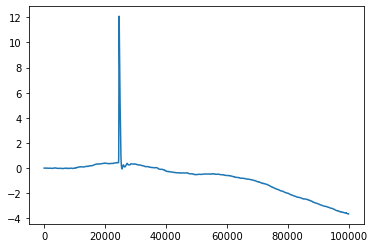

In [41]:
plt.plot(Bvelx)#There's some drift in the integration, so we'll have to subtract out the baseline when plotting

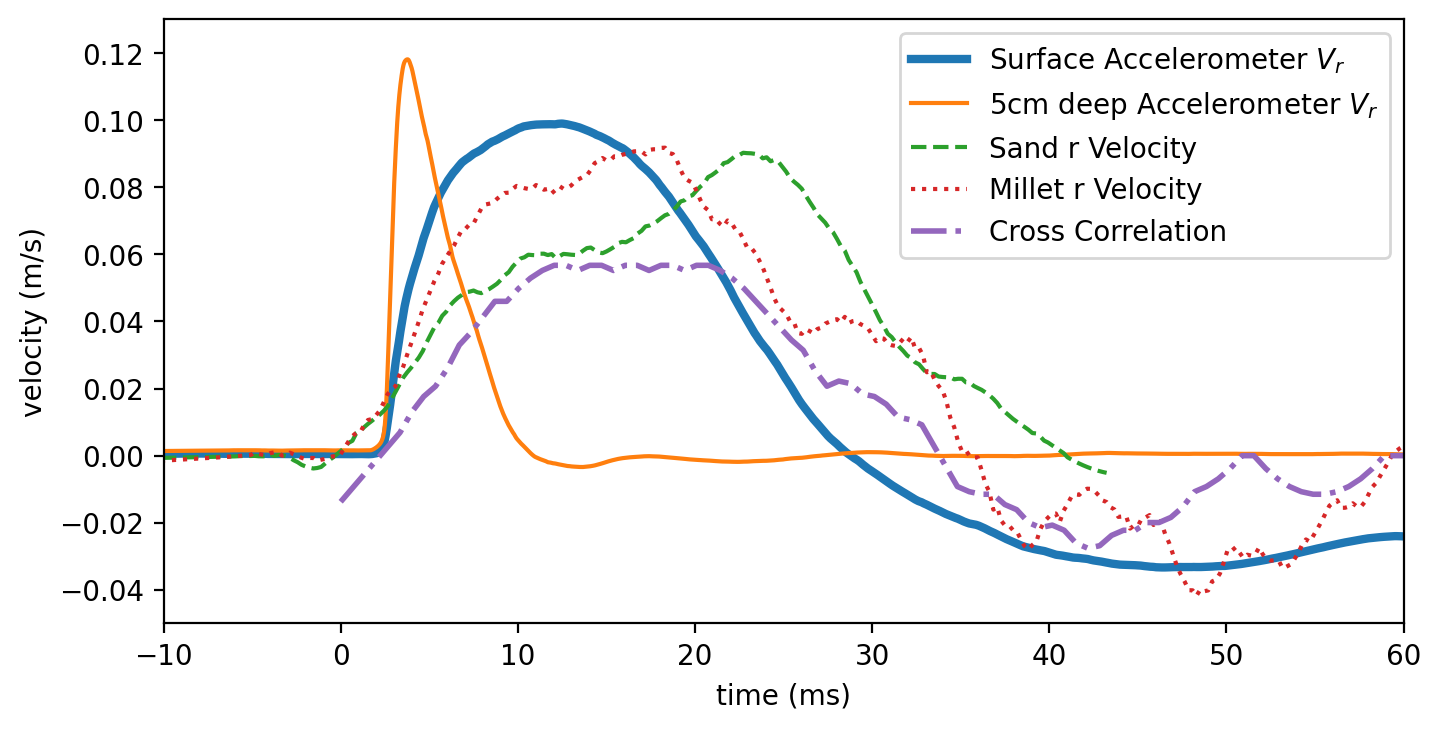

In [44]:
plt.figure(figsize=(8,4),dpi=200); 
plt.plot((Timex[:]-.13237)*1000-10.15, Avelx[:]/100, label = "Surface Accelerometer $V_r$", lw = 3)
plt.plot((Timex[:]-.13237)*1000-10.15, Bvelx[:]/100 - find_baseline(Bvelx[25000:])/100, label = "5cm deep Accelerometer $V_r$") #to reduce drift from integration
plt.plot(seconds[:243]*1000-10.15,savgol_filter(-1*differentiate(savgol_filter(shifts[0,2,:243],51,2),fps)/100,21,2), label = "Sand r Velocity", ls = '--')
plt.plot(seconds[:end]*1000-10.15,savgol_filter(-1*differentiate(savgol_filter(shifts[0,12,:end],51,2),fps)/100,21,2), label = "Millet r Velocity", ls = ':')
#plt.plot(xt[:119],differentiate(savgol_filter(cx[0,:119],11,2),fps/3)/1000, label = "Cross Correlation")
plt.plot(xt[:119],savgol_filter(cx[0,:119],11,2,deriv=1,delta=0.67), label = "Cross Correlation", ls = "-.", lw = 2)
#plt.plot(xt[:],(savgol_filter(cx[0,:119],11,2)))
#plt.plot(seconds[:243]*1000-10.15, -1*savgol_filter(shifts[0,2,:243],51,2))
#plt.plot(xt[:],((cx[0,:119])), label = "Raw cross correlation position data")
plt.xlim(-10, 60)
plt.ylim(-.05, 0.13)
plt.legend()
#plt.title("Radial velocities")
plt.ylabel("velocity (m/s)")
plt.xlabel("time (ms)")
plt.savefig("comp4_accel.png", dpi=500)

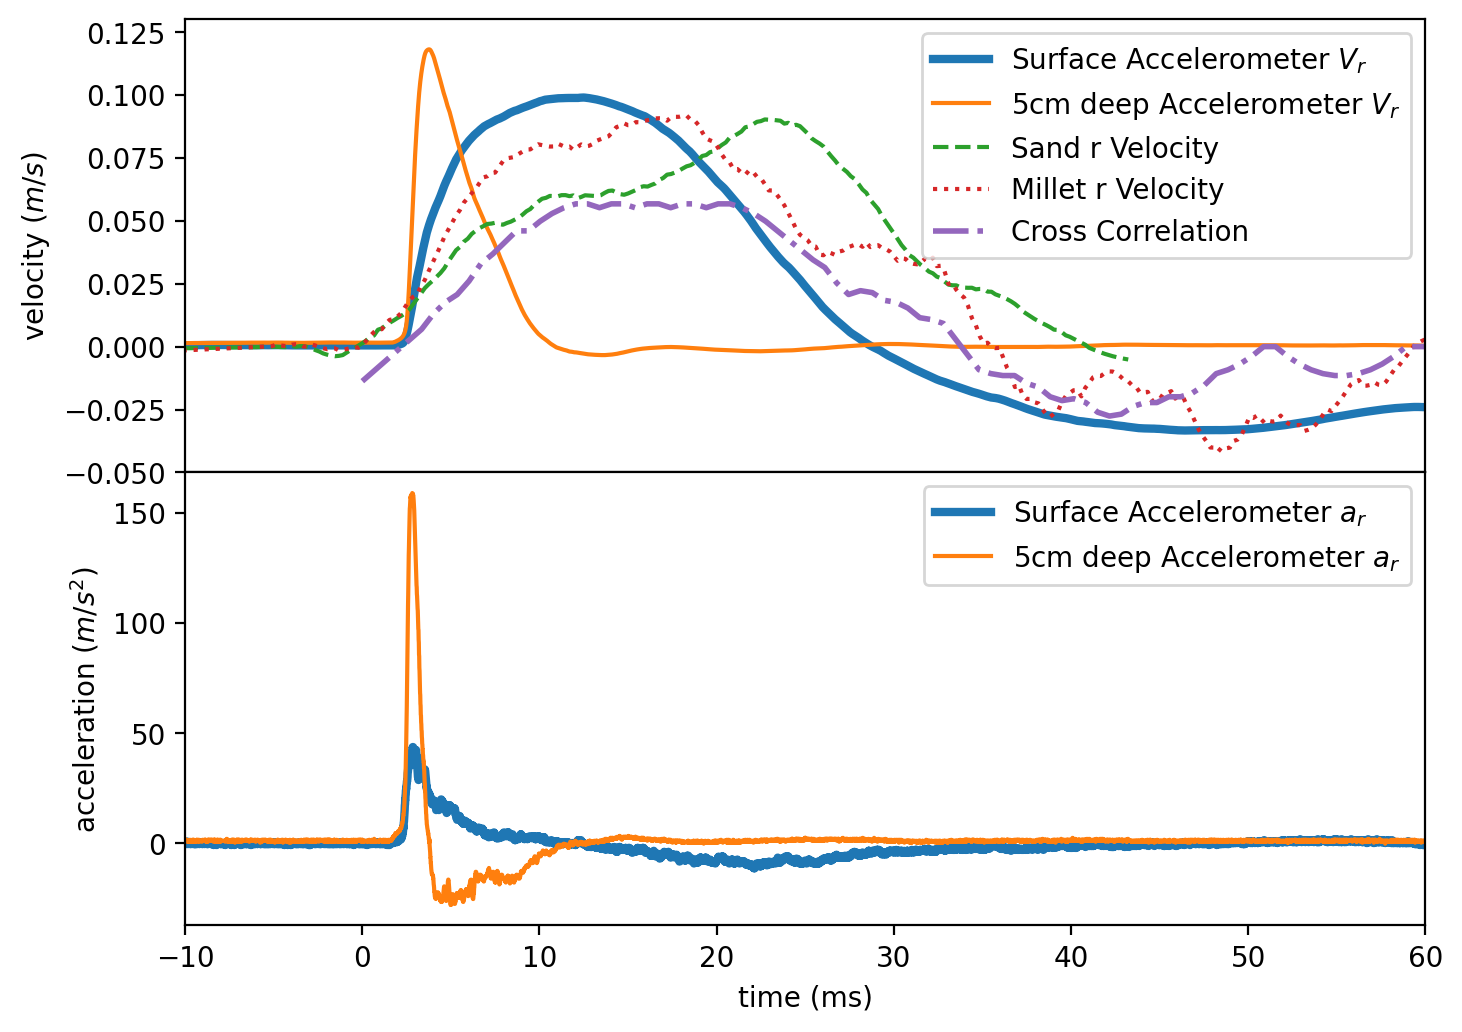

In [46]:
fig = plt.figure(figsize=(8,6),dpi=200); 
gs = fig.add_gridspec(2, 1, hspace=0, wspace=0)
(ax1, ax2) = gs.subplots(sharex='col', sharey='row')

ax1.plot((Timex[:]-.13237)*1000-10.15, Avelx[:]/100, label = "Surface Accelerometer $V_r$", lw = 3)
ax1.plot((Timex[:]-.13237)*1000-10.15, Bvelx[:]/100 - find_baseline(Bvelx[25000:])/100, label = "5cm deep Accelerometer $V_r$")
ax1.plot(seconds[:243]*1000-10.15,savgol_filter(-1*differentiate(savgol_filter(shifts[0,2,:243],51,2),fps)/100,21,2), label = "Sand r Velocity", ls = '--')
ax1.plot(seconds[:end]*1000-10.15,savgol_filter(-1*differentiate(savgol_filter(shifts[0,12,:end],51,2),fps)/100,21,2), label = "Millet r Velocity", ls = ':')
ax1.plot(xt[:119],savgol_filter(cx[0,:119],11,2,deriv=1,delta=0.67), label = "Cross Correlation", ls = "-.", lw = 2)

#ax2.plot((Timex[:]-.13237)*1000-10.15, Avelx[:]/100, label = "Surface Accelerometer $V_r$", lw = 3)
#ax2.plot((Timex[:]-.13237)*1000-10.15, Bvelx[:]/100, label = "5cm deep Accelerometer $V_r$")
ax2.plot((Timex[:]-.13237)*1000-10.15, Aaccelx[:]/100, label = "Surface Accelerometer $a_r$", lw = 3)
ax2.plot((Timex[:]-.13237)*1000-10.15, Baccelx[:]/100, label = "5cm deep Accelerometer $a_r$")

ax1.set_xlim(-10, 60)
ax1.set_ylim(-.05, 0.13)
ax1.legend()
ax2.legend()
#plt.title("Radial velocities")
ax1.set_ylabel("velocity ($m/s$)")
ax1.get_xaxis().set_visible(False)
ax2.set_xlabel("time (ms)")
ax2.set_ylabel("acceleration ($m/s^2$)")
plt.savefig("comp4_accel.png", dpi=500)

In [47]:
start = 24000
end = 30000
Aposx = sub_integrate_vel(Avelx, start, end, Timex)
Bposx = sub_integrate_vel(Bvelx, start, 26000, Timex)

Aposy = sub_integrate_vel(Avely, start, end, Timey)
Bposy = sub_integrate_vel(Bvely, start, 26000, Timey)

Text(0.5, 1.0, 'Radial displacements')

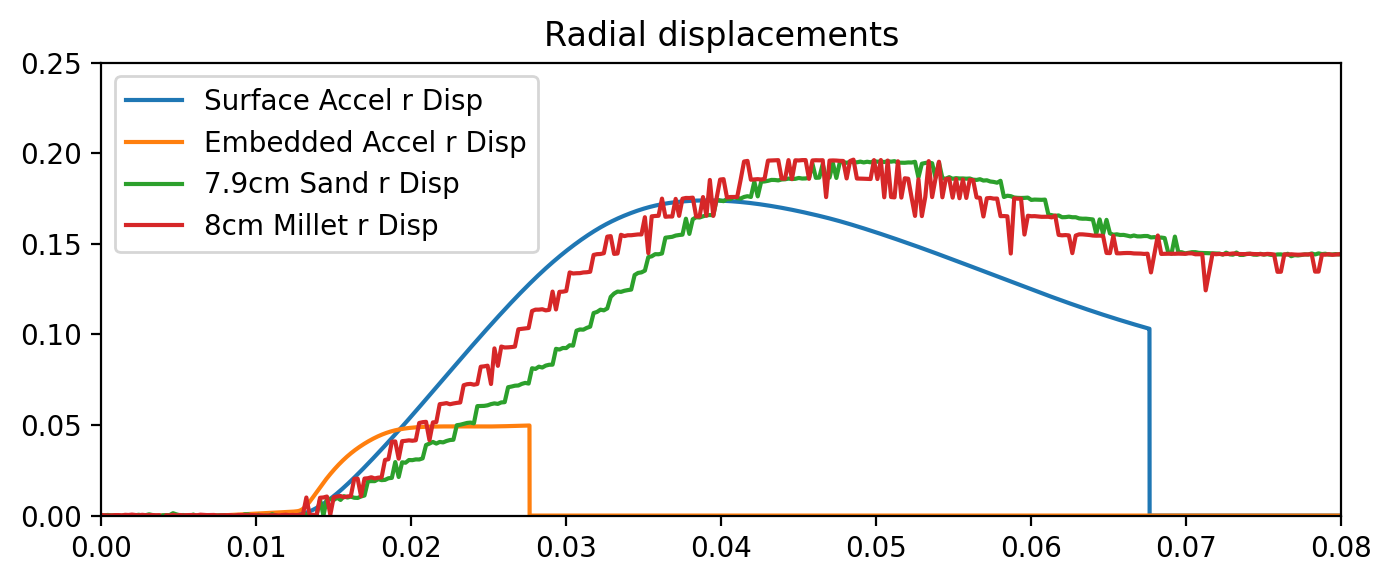

In [48]:
plt.figure(figsize=(8,3),dpi=200); 
plt.plot(Timex[:]-.13237, Aposx[:], label = "Surface Accel r Disp")
plt.plot(Timex[:]-.13237, Bposx[:], label = "Embedded Accel r Disp")
plt.plot(seconds[:end],-1*shifts[0,2,:end], label = "7.9cm Sand r Disp")
plt.plot(seconds[:end],-1*shifts[0,12,:end], label = "8cm Millet r Disp")
#plt.plot(seconds[:end],-1*savgol_filter(shifts[0,2,:end],61,2), label = "7.9cm Sand r Velocity")
#plt.plot(seconds[:end],-1*savgol_filter(shifts[0,12,:end],61,2), label = "8cm Millet r Velocity")
plt.xlim(0, 0.08)
plt.ylim(0, 0.25)
plt.legend()
plt.title("Radial displacements")

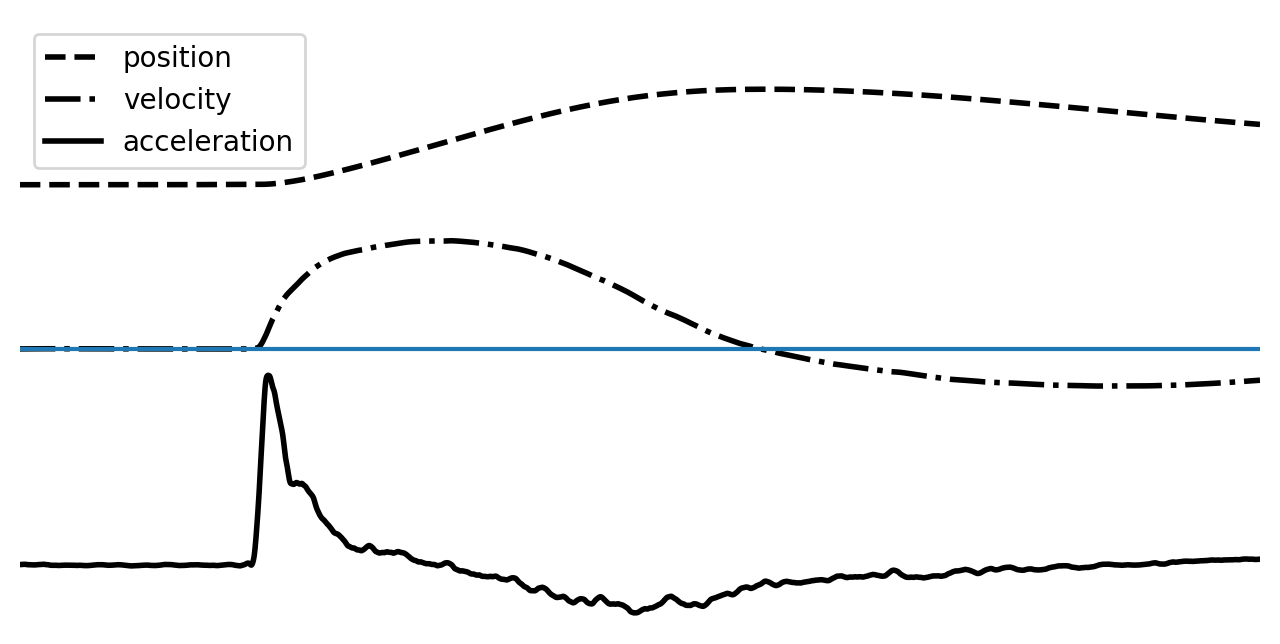

In [49]:
plt.figure(figsize=(8,4),dpi=200); 
plt.plot(Timex[:]-.13237, 50*Aposx[:]+35, ls = "--", lw = 2, c = "black", label = "position")
plt.plot(Timex[:]-.13237, Avelx[:]+20, ls = "-.", lw = 2, c = "black", label = "velocity")
plt.plot([0,70],[20,20])
plt.plot(Timex[:]-.13237, (savgol_filter(((70*Accel_xdata[0,:]-1.6)-110),101,2)),lw = 2, c = "black", label = "acceleration")
plt.xlim(0,0.065)
plt.ylim(-5,50)
plt.legend()
plt.axis('off')
plt.savefig("derivatives.png", dpi=500)